# **Topic Modeling with Llama2** 🦙
*Create easily interpretable topics with BERTopic and Llama 2*
<br>
<div>
<img src="https://github.com/MaartenGr/BERTopic/assets/25746895/35441954-4405-465c-97f7-a57ee91315b8" width="750"/>
</div>


We will explore how we can use Llama2 for Topic Modeling without the need to pass every single document to the model. Instead, we are going to leverage BERTopic, a modular topic modeling technique that can use any LLM for fine-tuning topic representations.

BERTopic works rather straightforward. It consists of 5 sequential steps: embedding documents, reducing embeddings in dimensionality, cluster embeddings, tokenize documents per cluster, and finally extract the best representing words per topic.
<br>
<div>
<img src="https://github.com/MaartenGr/BERTopic/assets/25746895/e9b0d8cf-2e19-4bf1-beb4-4ff2d9fa5e2d" width="500"/>
</div>

However, with the rise of LLMs like **Llama 2**, we can do much better than a bunch of independent words per topic. It is computally not feasible to pass all documents to Llama 2 directly and have it analyze them. We can employ vector databases for search but we are not entirely search which topics to search for.

Instead, we will leverage the clusters and topics that were created by BERTopic and have Llama 2 fine-tune and distill that information into something more accurate.

This is the best of both worlds, the topic creation of BERTopic together with the topic representation of Llama 2.
<br>
<div>
<img src="https://github.com/MaartenGr/BERTopic/assets/25746895/7c7374a1-5b41-4e93-aafd-a1587367767b" width="500"/>
</div>

Now that this intro is out of the way, let's start the hands-on tutorial!

# 📄 **Data**

We are going to apply topic modeling on a number of ArXiv abstracts. They are a great source for topic modeling since they contain a wide variety of topics and are generally well-written.

In [1]:
from urbandev.utils import load_dataset

docs, labels, timestamps = load_dataset(type='sklearn')
# Extract abstracts to train on and corresponding titles


To give you an idea, a doc looks like the following:

In [2]:
# The abstract of "Attention Is All You Need"
print(docs[13894])

Fully implement gender equality at the constitutional and criminal law levels_According to Article 7 of the Constitution, the people of the Republic of China, regardless of gender, religion, race, class, or party affiliation, are equal in law. Among them, "no distinction between men and women" negates the existence of other genders based on gender dualism, and should be revised as no distinction between genders. In addition, ethnic groups that are not at the two ends of the gender spectrum and whose sexual orientation is not mainstream have not received due protection at the constitutional level. Therefore, in addition to gender, religion, race, class, and party affiliation, gender identity and sexual orientation should be added. Article 7 of the amended Constitution reads: "The people of the Republic of China, regardless of sex, gender identity, sexual orientation, religion, race, class, or party affiliation, are equal in law." In addition, a new law should be enacted to impose crimin

# 🤗 HuggingFace Hub Credentials
Before we can load in Llama2 using a number of tricks, we will first need to accept the License for using Llama2. The steps are as follows:


* Create a HuggingFace account [here](https://huggingface.co)
* Apply for Llama 2 access [here](https://huggingface.co/meta-llama/Llama-2-13b-chat-hf)
* Get your HuggingFace token [here](https://huggingface.co/settings/tokens)

After doing so, we can login with our HuggingFace credentials so that this environment knows we have permission to download the Llama 2 model that we are interested in.

In [3]:
from huggingface_hub import notebook_login
notebook_login()

# 🦙 **Llama 2**

Now comes one of the more interesting components of this tutorial, how to load in a Llama 2 model on a T4-GPU!

We will be focusing on the `'meta-llama/Llama-2-13b-chat-hf'` variant. It is large enough to give interesting and useful results whilst small enough that it can be run on our environment.

We start by defining our model and identifying if our GPU is correctly selected. We expect the output of `device` to show a cuda device:

In [4]:
from torch import cuda

model_id = 'meta-llama/Llama-2-13b-chat-hf'
device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

print(device)

cuda:0


## **Optimization & Quantization**

In order to load our 13 billion parameter model, we will need to perform some optimization tricks. Since we have limited VRAM and not an A100 GPU, we will need to "condense" the model a bit so that we can run it.

There are a number of tricks that we can use but the main principle is going to be 4-bit quantization.

This process reduces the 64-bit representation to only 4-bits which reduces the GPU memory that we will need. It is a recent technique and quite an elegant at that for efficient LLM loading and usage. You can find more about that method [here](https://arxiv.org/pdf/2305.14314.pdf) in the QLoRA paper and on the amazing HuggingFace blog [here](https://huggingface.co/blog/4bit-transformers-bitsandbytes).

In [5]:
from torch import bfloat16
import transformers

# set quantization configuration to load large model with less GPU memory
# this requires the `bitsandbytes` library

bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,  # 4-bit quantization
    bnb_4bit_quant_type='nf4',  # Normalized float 4
    bnb_4bit_use_double_quant=True,  # Second quantization after the first
    bnb_4bit_compute_dtype=bfloat16,  # Computation type
    llm_int8_enable_fp32_cpu_offload=True
)

These four parameters that we just run are incredibly important and bring many LLM applications to consumers:
* `load_in_4bit`
  * Allows us to load the model in 4-bit precision compared to the original 32-bit precision
  * This gives us an incredibly speed up and reduces memory!
* `bnb_4bit_quant_type`
  * This is the type of 4-bit precision. The paper recommends normalized float 4-bit, so that is what we are going to use!
* `bnb_4bit_use_double_quant`
  * This is a neat trick as it perform a second quantization after the first which further reduces the necessary bits
* `bnb_4bit_compute_dtype`
  * The compute type used during computation, which further speeds up the model.



Using this configuration, we can start loading in the model as well as the tokenizer:

In [6]:
# Llama 2 Tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(model_id)


device_map = {
    "transformer.word_embeddings": 0,
    "transformer.word_embeddings_layernorm": 0,
    "lm_head": "cpu",
    "transformer.h": 0,
    "transformer.ln_f": 0,
    "model.embed_tokens": "cpu",
    "model.layers.0.input_layernorm.weight": "cpu",
    "model.layers.0.mlp.down_proj.weight": "cpu",
    "model.layers.0.mlp.gate_proj.weight": "cpu",
    "model.layers.0.mlp.up_proj.weight": "cpu",
    "model.layers.0.post_attention_layernorm.weight": "cpu",
    "model.layers.0.self_attn.k_proj.weight": "cpu",
    "model.layers.0.self_attn.o_proj.weight": "cpu",
    "model.layers.0.self_attn.q_proj.weight": "cpu",
    "model.layers": "cpu",
    "model.norm.weight": "cpu"
}

# Llama 2 Model
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    quantization_config=bnb_config,
    device_map='auto',

)
model.eval()

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 5120, padding_idx=0)
    (layers): ModuleList(
      (0-39): 40 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (v_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (o_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (up_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (down_proj): Linear4bit(in_features=13824, out_features=5120, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )


Using the model and tokenizer, we will generate a HuggingFace transformers pipeline that allows us to easily generate new text:

In [7]:
# Our text generator
generator = transformers.pipeline(
    model=model, tokenizer=tokenizer,
    task='text-generation',
    temperature=0.0,
    max_new_tokens=500,
    repetition_penalty=1.1
)

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


## **Prompt Engineering**

To check whether our model is correctly loaded, let's try it out with a few prompts.

In [8]:
prompt = "Could you explain to me how 4-bit quantization works as if I am 5?"
res = generator(prompt)
print(res[0]["generated_text"])

Could you explain to me how 4-bit quantization works as if I am 5?

Sure! Imagine you have a big box of crayons. Each crayon represents a different color, like red, blue, green, and so on. Now, imagine that instead of using all the different colors, we only use four colors: red, blue, green, and yellow. This is like 4-bit quantization.

So, when we want to draw a picture, we can only choose one of these four colors to use. We can't mix them together or use any other colors. It's like we're limited to just these four colors.

For example, let's say we want to draw a tree. We could use the green crayon to draw the leaves, but we couldn't use the blue crayon to draw the sky because it's not one of our allowed colors. Instead, we would have to use the yellow crayon to draw the sky.

This is kind of like how 4-bit quantization works in computers. Instead of using all the different numbers that a computer can represent, we only use four bits (or colors) to represent everything. So, instead o

Although we can directly prompt the model, there is actually a template that we need to follow. The template looks as follows:

```python
"""
<s>[INST] <<SYS>>

{{ System Prompt }}

<</SYS>>

{{ User Prompt }} [/INST]

{{ Model Answer }}
"""
```

This template consists of two main components, namely the `{{ System Prompt }}` and the `{{ User Prompt }}`:
* The `{{ System Prompt }}` helps us guide the model during a conversation. For example, we can say that it is a helpful assisant that is specialized in labeling topics.
* The  `{{ User Prompt }}` is where we ask it a question.

You might have noticed the `[INST]` tags, these are used to identify the beginning and end of a prompt. We can use these to model the conversation history as we will see more in-depth later on.

Next, let's see how we can use this template to optimize Llama 2 for topic modeling.

### **Prompt Template**

We are going to keep our `system prompt` simple and to the point:

In [9]:
# System prompt describes information given to all conversations
system_prompt = """
<s>[INST] <<SYS>>
You are a helpful, respectful and honest assistant for labeling topics.
<</SYS>>
"""

We will tell the model that it is simply a helpful assistant for labeling topics since that is our main goal.

In contrast, our `user prompt` is going to the be a bit more involved. It will consist of two components, an **example** and the **main prompt**.

Let's start with the **example**. Most LLMs do a much better job of generating accurate responses if you give them an example to work with. We will show it an accurate example of the kind of output we are expecting.

In [10]:
# Example prompt demonstrating the output we are looking for
example_prompt = """
I have a topic that contains the following documents:
- Traditional diets in most cultures were primarily plant-based with a little meat on top, but with the rise of industrial style meat production and factory farming, meat has become a staple food.
- Meat, but especially beef, is the word food in terms of emissions.
- Eating meat doesn't make you a bad person, not eating meat doesn't make you a good one.

The topic is described by the following keywords: 'meat, beef, eat, eating, emissions, steak, food, health, processed, chicken'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more.

[/INST] Environmental impacts of eating meat
"""

This example, based on a number of keywords and documents primarily about the impact of
meat, helps to model to understand the kind of output it should give. We show the model that we were expecting only the label, which is easier for us to extract.

Next, we will create a template that we can use within BERTopic:

In [11]:
# Our main prompt with documents ([DOCUMENTS]) and keywords ([KEYWORDS]) tags
main_prompt = """
[INST]
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more.
[/INST]
"""

There are two BERTopic-specific tags that are of interest, namely `[DOCUMENTS]` and `[KEYWORDS]`:

* `[DOCUMENTS]` contain the top 5 most relevant documents to the topic
* `[KEYWORDS]` contain the top 10 most relevant keywords to the topic as generated through c-TF-IDF

This template will be filled accordingly to each topic. And finally, we can combine this into our final prompt:

In [12]:
prompt = system_prompt + example_prompt + main_prompt

# 🗨️ **BERTopic**

Before we can start with topic modeling, we will first need to perform two steps:
* Pre-calculating Embeddings
* Defining Sub-models

## **Preparing Embeddings**

By pre-calculating the embeddings for each document, we can speed-up additional exploration steps and use the embeddings to quickly iterate over BERTopic's hyperparameters if needed.

🔥 **TIP**: You can find a great overview of good embeddings for clustering on the [MTEB Leaderboard](https://huggingface.co/spaces/mteb/leaderboard).

In [13]:
from sentence_transformers import SentenceTransformer

# Pre-calculate embeddings
embedding_model = SentenceTransformer("BAAI/bge-large-en")
embeddings = embedding_model.encode(docs, show_progress_bar=True)

Batches:   0%|          | 0/442 [00:00<?, ?it/s]

## **Sub-models**

Next, we will define all sub-models in BERTopic and do some small tweaks to the number of clusters to be created, setting random states, etc.

In [14]:
from umap import UMAP
from hdbscan import HDBSCAN

umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=150, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

/media/citi-ai/moritz/03_UrbanDevelopmentTaiwan/.venv/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/media/citi-ai/moritz/03_UrbanDevelopmentTaiwan/.venv/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/media/citi-ai/moritz/03_UrbanDe

As a small bonus, we are going to reduce the embeddings we created before to 2-dimensions so that we can use them for visualization purposes when we have created our topics.

In [15]:
# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

### **Representation Models**

One of the ways we are going to represent the topics is with Llama 2 which should give us a nice label. However, we might want to have additional representations to view a topic from multiple angles.

Here, we will be using c-TF-IDF as our main representation and [KeyBERT](https://maartengr.github.io/BERTopic/getting_started/representation/representation.html#keybertinspired), [MMR](https://maartengr.github.io/BERTopic/getting_started/representation/representation.html#maximalmarginalrelevance), and [Llama 2](https://maartengr.github.io/BERTopic/getting_started/representation/llm.html) as our additional representations.

In [16]:
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, TextGeneration

# KeyBERT
keybert = KeyBERTInspired()

# MMR
mmr = MaximalMarginalRelevance(diversity=0.3)

# Text generation with Llama 2
llama2 = TextGeneration(generator, prompt=prompt)

# All representation models
representation_model = {
    "KeyBERT": keybert,
    "Llama2": llama2,
    "MMR": mmr,
}

# 🔥 **Training**

Now that we have our models prepared, we can start training our topic model! We supply BERTopic with the sub-models of interest, run `.fit_transform`, and see what kind of topics we get.

In [17]:
from bertopic import BERTopic

topic_model = BERTopic(

  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=10,
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(docs, embeddings)


2023-08-30 17:29:05,779 - BERTopic - Reduced dimensionality
2023-08-30 17:29:06,485 - BERTopic - Clustered reduced embeddings
100%|██████████| 15/15 [00:08<00:00,  1.75it/s]


Now that we are done training our model, let's see what topics were generated:

In [18]:
# Show topics
topic_model.get_topic_info()

Topic  Count                                 Name  \
0      -1   4004                     -1_the_and_of_to   
1       0   3329                      0_the_to_and_of   
2       1   1302             1_students_school_the_to   
3       2    966                      2_the_and_of_to   
4       3    895                      3_the_to_of_and   
5       4    603                      4_the_to_of_and   
6       5    558                    5_labor_the_of_to   
7       6    466                       6_the_of_to_be   
8       7    464                7_the_election_of_and   
9       8    372              8_china_republic_of_the   
10      9    306            9_animal_animals_dogs_and   
11     10    250  10_smoking_smoke_tobacco_cigarettes   
12     11    219                11_media_the_news_and   
13     12    204           12_military_service_the_of   
14     13    181         13_childcare_children_the_to   

                                       Representation  \
0       [the, and, of, to, in, is, for, be, that, it]   
1   [the, to, and, of, is, be, driving, traffic, i...   
2   [students, school, the, to, and, of, in, educa...   
3   [the, and, of, to, in, is, power, it, food, that]   
4   [the, to, of, and, epidemic, medical, in, heal...   
5   [the, to, of, and, is, tax, housing, land, for...   
6   [labor, the, of, to, workers, and, hours, sala...   
7   [the, of, to, be, death, and, criminal, is, im...   
8   [the, election, of, and, to, political, be, is...   
9   [china, republic, of, the, taiwan, and, to, co...   
10  [animal, animals, dogs, and, the, stray, to, c...   
11  [smoking, smoke, tobacco, cigarettes, cigarett...   
12  [media, the, news, and, of, to, information, o...   
13  [military, service, the, of, to, women, and, i...   
14  [childcare, children, the, to, of, and, is, fo...   

                                              KeyBERT  \
0   [china, civil, article, in, taiwan, country, y...   
1   [taiwan, highway, road, accident, expressway, ...   
2   [schools, school, education, taiwan, students,...   
3   [taiwan, energy, nuclear, environment, solar, ...   
4   [taiwan, wuhan, country, epidemic, national, p...   
5   [taiwan, housing, land, houses, yuan, house, i...   
6   [labor, workers, wages, employer, employees, e...   
7   [sentenced, imprisonment, homicide, parole, ta...   
8   [electoral, election, elections, voters, candi...   
9   [china, taiwan, chinese, macau, republic, coun...   
10  [pet, taiwan, animal, animals, neutering, law,...   
11  [tobacco, smokers, cigarettes, smoking, cigare...   
12  [article, media, broadcasting, political, repo...   
13  [conscription, equality, society, military, ar...   
14  [childcare, kindergartens, policy, subsidy, co...   

                                               Llama2  \
0    [Government and Social Reform, , , , , , , , , ]   
1         [Road Safety Regulations, , , , , , , , , ]   
2   [Reforms in Taiwanese Education, , , , , , , ,...   
3   [Government initiatives for sustainable energy...   
4   [\nGovernment Response to COVID-19 Epidemic, ,...   
5       [Housing market regulation, , , , , , , , , ]   
6   [Labor Rights and Compensation, , , , , , , , , ]   
7   [Criminal Justice Reform in Taiwan, , , , , , ...   
8                [Electoral reform, , , , , , , , , ]   
9   [Name changes and political issues in China an...   
10  [Animal welfare and protection policies in Tai...   
11      [Tobacco Control in Taiwan, , , , , , , , , ]   
12  [Media Regulation and False Information Online...   
13    [Gender and Military Service, , , , , , , , , ]   
14     [Childcare Policy Proposals, , , , , , , , , ]   

                                                  MMR  \
0       [the, and, of, to, in, is, for, be, that, it]   
1   [the, to, and, of, is, be, driving, traffic, i...   
2   [students, school, the, to, and, of, in, educa...   
3   [the, and, of, to, in, is, power, it, food, that]   
4   [the, to, of, and, epidemic, medical, in, heal...   
5   [the, 

We got over 100 topics that were created and they all seem quite diverse.We can use the labels by Llama 2 and assign them to topics that we have created. Normally, the default topic representation would be c-TF-IDF, but we will focus on Llama 2 representations instead.


In [19]:
llama2_labels = [label[0][0].split("\n")[0] for label in topic_model.get_topics(full=True)["Llama2"].values()]
topic_model.set_topic_labels(llama2_labels)

# 📊 **Visualize**
We can go through each topic manually, which would take a lot of work, or we can visualize them all in a single interactive graph.
BERTopic has a bunch of [visualization functions](https://medium.com/r/?url=https%3A%2F%2Fmaartengr.github.io%2FBERTopic%2Fgetting_started%2Fvisualization%2Fvisualize_documents.html) that we can use. For now, we are sticking with visualizing the documents.

In [20]:
titles=[]
for doc in docs:
    titles.append(doc[:30])

In [21]:
topic_model.visualize_documents(titles, reduced_embeddings=reduced_embeddings, hide_annotations=True, hide_document_hover=True, custom_labels=True)

# 🖼️ (BONUS): **Advanced Visualization**

Although we can use the built-in visualization features of BERTopic, we can also create a static visualization that might be a bit more informative.

We start by creating the necessary variables that contain our reduced embeddings and representations:

In [22]:
set(topic_model.topics_) 

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}

In [23]:
import itertools
import pandas as pd

# Define colors for the visualization to iterate over
colors = itertools.cycle(['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000'])
color_key = {str(topic): next(colors) for topic in set(topic_model.topics_) if topic != -1}

# Prepare dataframe and ignore outliers
df = pd.DataFrame({"x": reduced_embeddings[:, 0], "y": reduced_embeddings[:, 1], "Topic": [str(t) for t in topic_model.topics_]})
df["Length"] = [len(doc) for doc in docs]
df = df.loc[df.Topic != "-1"]
df = df.loc[(df.y > -10) & (df.y < 10) & (df.x < 10) & (df.x > -10), :]
df["Topic"] = df["Topic"].astype("category")

# Get centroids of clusters
mean_df = df.groupby("Topic").mean().reset_index()
mean_df.Topic = mean_df.Topic.astype(int)
mean_df = mean_df.sort_values("Topic")

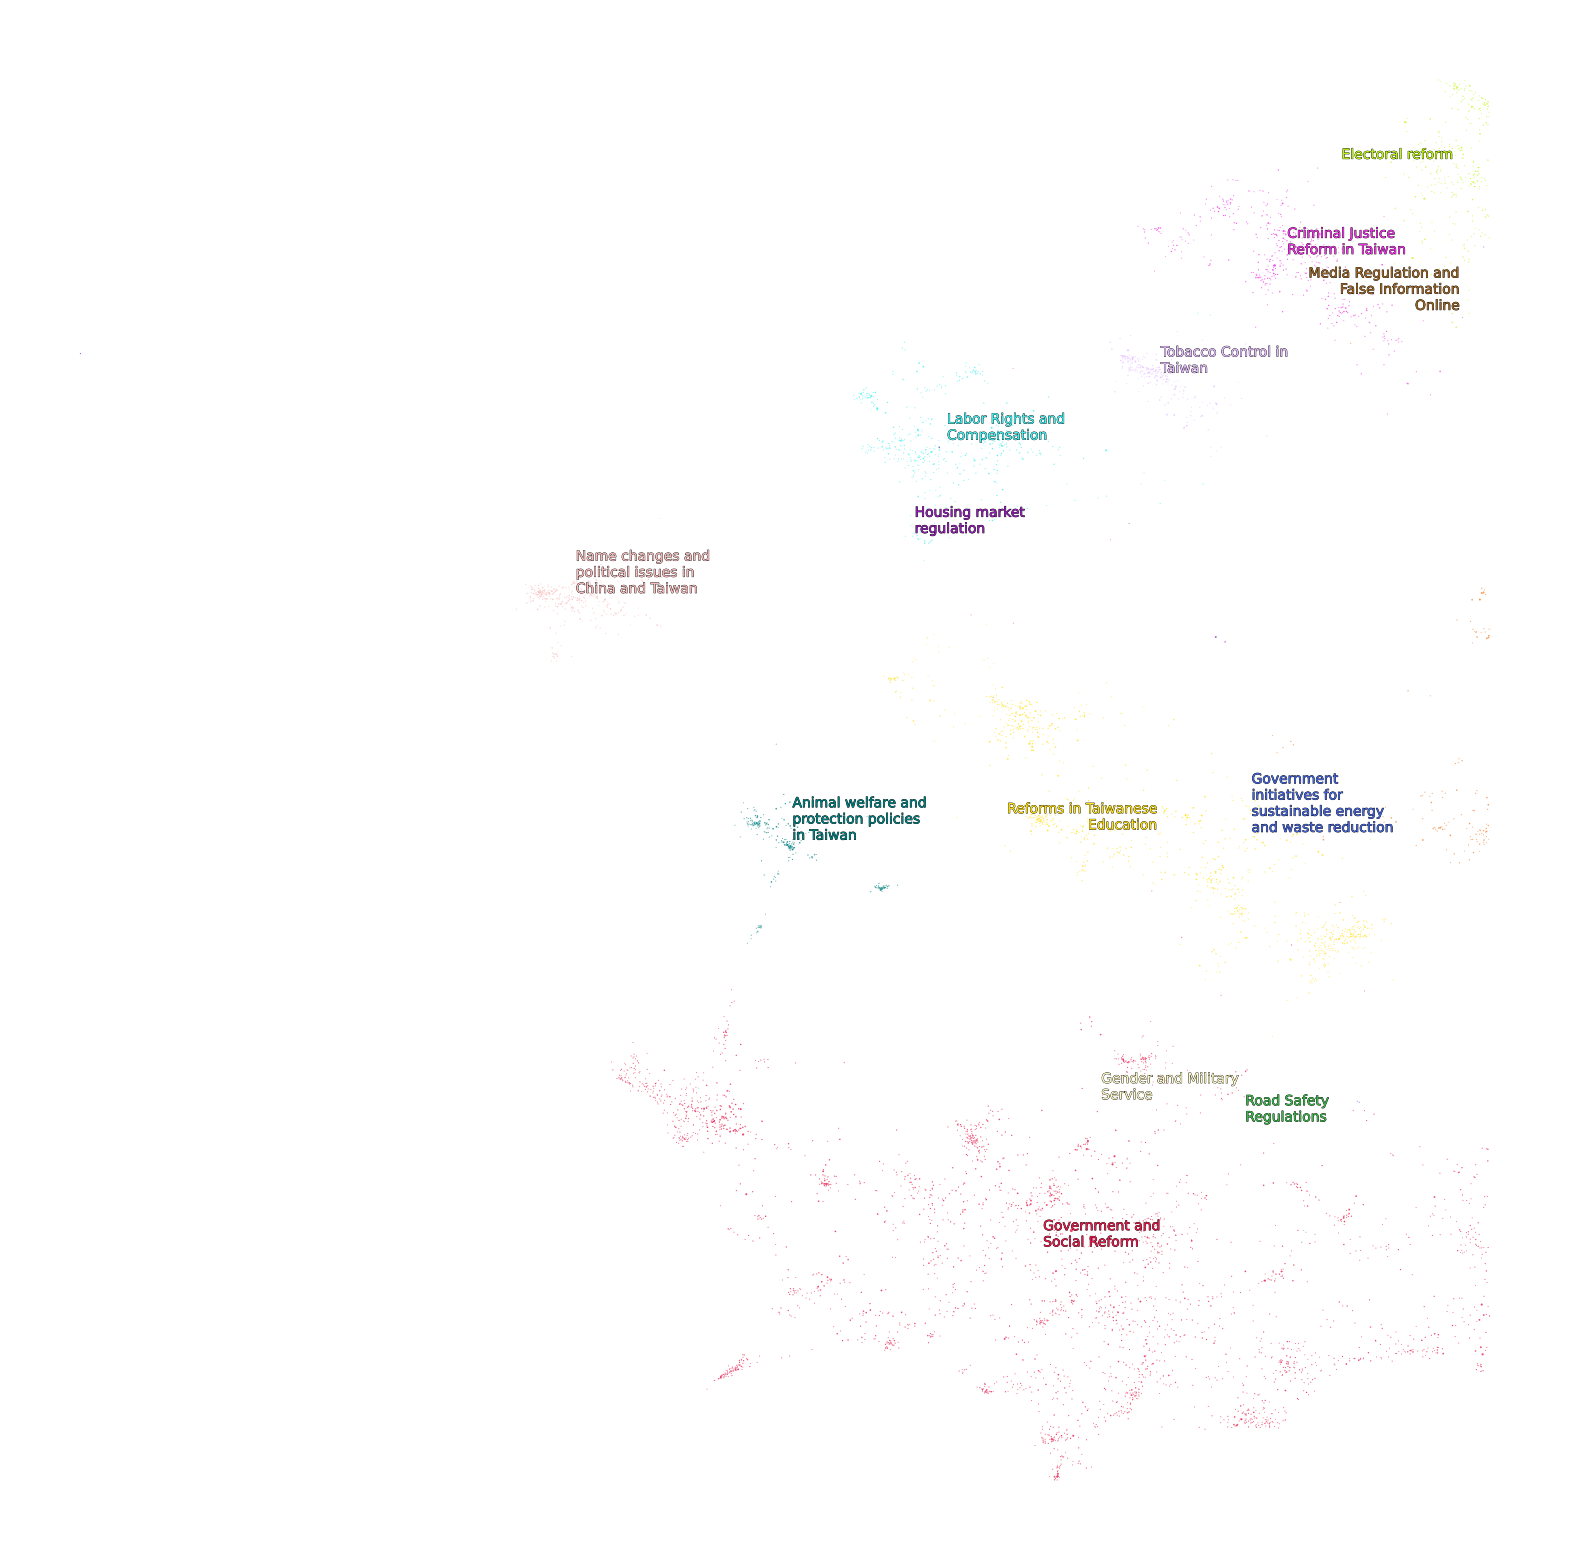

In [24]:
import seaborn as sns
from matplotlib import pyplot as plt
from adjustText import adjust_text
import matplotlib.patheffects as pe
import textwrap

fig = plt.figure(figsize=(20, 20))
sns.scatterplot(data=df, x='x', y='y', c=df['Topic'].map(color_key), alpha=0.8, sizes=(0.4, 10), size="Length")

# Annotate top 50 topics
texts, xs, ys = [], [], []
for row in mean_df.iterrows():
  topic = row[1]["Topic"]
  name = textwrap.fill(topic_model.custom_labels_[int(topic)], 20)

  if int(topic) <= 50:
    xs.append(row[1]["x"])
    ys.append(row[1]["y"])
    texts.append(plt.text(row[1]["x"], row[1]["y"], name, size=10, ha="center", color=color_key[str(int(topic))],
                          path_effects=[pe.withStroke(linewidth=0.5, foreground="black")]
                          ))

# Adjust annotations such that they do not overlap
adjust_text(texts, x=xs, y=ys, time_lim=1, force_text=(0.01, 0.02), force_static=(0.01, 0.02), force_pull=(0.5, 0.5))
plt.axis('off')
plt.legend('', frameon=False)
plt.show()

# Backup Saving

In [25]:
# To save: model, reduced embeddings, representative docs
!pip install safetensors

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [26]:
import pickle

with open('rep_docs.pickle', 'wb') as handle:
    pickle.dump(topic_model.representative_docs_, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('reduced_embeddings.pickle', 'wb') as handle:
    pickle.dump(reduced_embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

In [27]:
embedding_model = "BAAI/bge-large-en"
topic_model.save("final", serialization="safetensors", save_ctfidf=True, save_embedding_model=embedding_model)

In [28]:
!zip -r /content/llama2.zip /content/final


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	zip warning: name not matched: /content/final

zip error: Nothing to do! (try: zip -r /content/llama2.zip . -i /content/final)


In [29]:
!jupyter nbconvert --to markdown TopicModelingLlama2.ipynb

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
[NbConvertApp] Converting notebook TopicModelingLlama2.ipynb to markdown
/media/citi-ai/moritz/03_UrbanDevelopmentTaiwan/.venv/lib/python3.11/site-packages/nbconvert/filters/datatypefilter.py:39: UserWarning: Your element with mimetype(s) dict_keys(['application/vnd.plotly.v1+json']) is not able to be represented.
  warn("Your element with mimetype(s) {mimetypes}"
[NbConvertApp] Support files will be in TopicModelingLlama2_files/
[NbConvertApp] Making directory TopicModelingLlama2_files
[NbConvertApp] Writing 3080741 bytes to TopicModelingLlama2.md


In [30]:
from numpy import dot
from numpy.linalg import norm

def get_cos_sim(a, b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim

closest_topic = []
for emb in embeddings:
    sims=[]
    for i in range(len(topic_model.topic_embeddings_)):
        b=topic_model.topic_embeddings_[i]
        cos_sim=get_cos_sim(emb,b)
        print(cos_sim)
        sims.append(cos_sim)
    n=sims.index(max(sims))
    #print(n)
    closest_topic.append(n-1)


0.83588713
0.8226198
0.80093056
0.82443726
0.81855977
0.8222218
0.8320679
0.87941206
0.8217689
0.7970228
0.8820834
0.814827
0.8228849
0.8120752
0.8033811
0.8800955
0.8560865
0.8469825
0.8664462
0.85775405
0.885399
0.86954236
0.8453341
0.86765534
0.8816517
0.842662
0.83952403
0.8516305
0.8371844
0.8487391
0.8706804
0.8475595
0.8475284
0.84993863
0.8842987
0.845184
0.85474676
0.8824091
0.8468063
0.82738495
0.84778655
0.846305
0.86005574
0.83675635
0.8369287
0.82998824
0.8569082
0.8059846
0.8142973
0.8131432
0.8113513
0.81958073
0.8680659
0.81439376
0.77251714
0.8198104
0.80287
0.8200906
0.7977627
0.80405074
0.8818259
0.8524377
0.85721135
0.8669074
0.8706042
0.87156165
0.87690926
0.8502262
0.8583839
0.8492436
0.8453669
0.84150875
0.84461755
0.85357577
0.93214226
0.91395706
0.88053614
0.8838169
0.8992817
0.90192246
0.90922517
0.9109314
0.87932634
0.8907517
0.88275605
0.8767332
0.86354685
0.88638353
0.876092
0.93935657
0.89982736
0.8798095
0.86597025
0.8995045
0.89761025
0.8901941
0.8660630

In [31]:
topic_model.get_topic_info()

Topic  Count                                 Name  \
0      -1   4004                     -1_the_and_of_to   
1       0   3329                      0_the_to_and_of   
2       1   1302             1_students_school_the_to   
3       2    966                      2_the_and_of_to   
4       3    895                      3_the_to_of_and   
5       4    603                      4_the_to_of_and   
6       5    558                    5_labor_the_of_to   
7       6    466                       6_the_of_to_be   
8       7    464                7_the_election_of_and   
9       8    372              8_china_republic_of_the   
10      9    306            9_animal_animals_dogs_and   
11     10    250  10_smoking_smoke_tobacco_cigarettes   
12     11    219                11_media_the_news_and   
13     12    204           12_military_service_the_of   
14     13    181         13_childcare_children_the_to   

                                           CustomName  \
0                        Government and Social Reform   
1                             Road Safety Regulations   
2                      Reforms in Taiwanese Education   
3   Government initiatives for sustainable energy ...   
4                                                       
5                           Housing market regulation   
6                       Labor Rights and Compensation   
7                   Criminal Justice Reform in Taiwan   
8                                    Electoral reform   
9   Name changes and political issues in China and...   
10   Animal welfare and protection policies in Taiwan   
11                          Tobacco Control in Taiwan   
12      Media Regulation and False Information Online   
13                        Gender and Military Service   
14                         Childcare Policy Proposals   

                                       Representation  \
0       [the, and, of, to, in, is, for, be, that, it]   
1   [the, to, and, of, is, be, driving, traffic, i...   
2   [students, school, the, to, and, of, in, educa...   
3   [the, and, of, to, in, is, power, it, food, that]   
4   [the, to, of, and, epidemic, medical, in, heal...   
5   [the, to, of, and, is, tax, housing, land, for...   
6   [labor, the, of, to, workers, and, hours, sala...   
7   [the, of, to, be, death, and, criminal, is, im...   
8   [the, election, of, and, to, political, be, is...   
9   [china, republic, of, the, taiwan, and, to, co...   
10  [animal, animals, dogs, and, the, stray, to, c...   
11  [smoking, smoke, tobacco, cigarettes, cigarett...   
12  [media, the, news, and, of, to, information, o...   
13  [military, service, the, of, to, women, and, i...   
14  [childcare, children, the, to, of, and, is, fo...   

                                              KeyBERT  \
0   [china, civil, article, in, taiwan, country, y...   
1   [taiwan, highway, road, accident, expressway, ...   
2   [schools, school, education, taiwan, students,...   
3   [taiwan, energy, nuclear, environment, solar, ...   
4   [taiwan, wuhan, country, epidemic, national, p...   
5   [taiwan, housing, land, houses, yuan, house, i...   
6   [labor, workers, wages, employer, employees, e...   
7   [sentenced, imprisonment, homicide, parole, ta...   
8   [electoral, election, elections, voters, candi...   
9   [china, taiwan, chinese, macau, republic, coun...   
10  [pet, taiwan, animal, animals, neutering, law,...   
11  [tobacco, smokers, cigarettes, smoking, cigare...   
12  [article, media, broadcasting, political, repo...   
13  [conscription, equality, society, military, ar...   
14  [childcare, kindergartens, policy, subsidy, co...   

                                               Llama2  \
0    [Government and Social Reform, , , , , , , , , ]   
1         [Road Safety Regulations, , , , , , , , , ]   
2   [Reforms in Taiwanese Education, , , , , , , ,...   
3   [Government initiatives for sustainable energy...   
4   [\nGovernment Response to COVID-19 Epidemic, ,...   
5       [H

In [32]:
topic_labels = [topic_model.get_topic_info().iloc[i]["Llama2"][0] for i in closest_topic]

In [37]:
data = load_dataset(type="pandas")
data.head()

Unnamed: 0                 date  \
0           0  2021-08-21 03:30:02   
1           1  2018-07-06 16:39:20   
2           2  2021-06-01 16:57:52   
3           3  2017-10-23 12:06:18   
4           4  2017-11-02 11:40:32   

                                                link  \
0  https://join.gov.tw/idea/detail/ebf6f1e8-665e-...   
1  https://join.gov.tw/idea/detail/b2506b9c-ddb8-...   
2  https://join.gov.tw/idea/detail/a680f567-2f53-...   
3  https://join.gov.tw/idea/detail/f2c4075f-04e7-...   
4  https://join.gov.tw/idea/detail/9ce8ce11-690c-...   

                           title_zh  \
0                   加重動物保護法中虐待動物的刑則   
1             名正言稅    請支持記帳士正名為稅務士！   
2  實施醫療暴力者應於健保系統註記，情節嚴重者應有對應之健保權利剝奪   
3  對酒駕累犯、性侵犯及對幼童傷害等增設刑法懲罰方式 增加 鞭刑制度   
4                  將育兒津貼從0～2歲改成0～6歲   

                                         proposal_zh  \
0  現今動物保護法，對虐待動物的犯人最重只處2年以下有期徒刑，對這些犯人跟本不痛不癢，而且過往案...   
1  ｜   台灣面向國際，從正名開始 \n  \n舉觀各國，美國、德國、韓國、日本等先進國家皆已...   
2  曾經有過醫療暴力行為之就醫者，應於健保系統註記，無論其暴力行為之緣由為何。若病人是因已診斷精...   
3   \n 對性侵犯除現行刑責外，追加鞭刑之懲罰。 \n 對傷害幼童之傷害以上罪犯除現行刑責外，...   
4  提議政府將育兒津貼從現今的0～2歲修改成0～6歲，也將補助金額從2500元增加到5000元視...   

                                         benefits_zh  upvotes  threshold  \
0  讓虐待動物的人受到應有的懲罰 \n提升對動物生命權的保護 \n藉由加重刑責或罰金，遏止虐待動...    44881       5000   
1  ｜   台灣稅務制度接軌國際，引領台灣中小企業走出台灣 \n記帳士是協助中小企業處理稅務的主...    39044       5000   
2  (1) 保障醫護及其他病患安全 \n就診者的暴力行為通常是突發性的，不一定有前兆，且影響範圍...    31856       5000   
3   \n 性侵犯對於被害者有極大的身心傷害，且再犯率極高，若增加鞭刑懲罰，不但可嚇阻其再犯之可...    31750       5000   
4  將育兒津貼的補助從原本0～2歲增加至0～6歲能減少家庭育兒負擔，且因應社會物價增長將原本的2...    17140       5000   

                date.1  num_followers  ...  \
0  2021-08-21 03:30:42           3253  ...   
1  2018-07-12 17:00:18            673  ...   
2  2021-06-01 17:38:48           1041  ...   
3  2017-10-23 12:06:33           2236  ...   
4  2017-11-02 11:41:17           1020  ...   

                                         proposal_en  \
0  According to the current animal protection law...   
1  ｜Taiwan is facing the world, starting from the...   
2  Those who have experienced medical violence sh...   
3  In addition to the current criminal responsibi...   
4  It is proposed that the government change the ...   

                                            title_en Unnamed: 16 Unnamed: 17  \
0  Increase the Penalty of Cruelty to Animals in ...         NaN         NaN   
1  Please support bookkeepers to be called tax co...         NaN         NaN   
2  Those who commit medical violence should make ...         NaN         NaN   
3  Added criminal law punishment methods for drun...         NaN         NaN   
4  Changed childcare allowance from 0-2 years old...         NaN         NaN   

  Unnamed: 18 Unnamed: 19 Unnamed: 20 Unnamed: 21 Unnamed: 22 label  
0         NaN         NaN         NaN         NaN         NaN   NaN  
1         NaN         NaN         NaN         NaN         NaN   NaN  
2         NaN         NaN         NaN         NaN         NaN   NaN  
3         NaN         NaN         NaN         NaN         NaN   NaN  
4         NaN         NaN         NaN         NaN         NaN   NaN  

[5 rows x 24 columns]

In [ ]:
data.insert(0, "BERTLabels", topics) 

In [38]:
# filter out passed proposals
a=data[data["upvotes"]>=data["threshold"]]
a = a[a["threshold"]>0]

In [34]:
topic_model.topic_representations_[4]

[('the', 0.052507496960143715),
 ('to', 0.03763973247102957),
 ('of', 0.03528852441335607),
 ('and', 0.03396959847731925),
 ('is', 0.030748835171086304),
 ('tax', 0.026230673950243297),
 ('housing', 0.025667975194560683),
 ('land', 0.024364001656710838),
 ('for', 0.024306534923074902),
 ('in', 0.02405983797188746)]

In [35]:
import numpy as np

#np.argmin(doc*topic_model.topic_embeddings)
np.argmax(embeddings[0]*topic_model.topic_embeddings_)

6049

In [36]:
# find the label according to calculating the min distance between topic_embedding and the doc embedding

for doc in docs:
    for top in topic_model.topic_embeddings_:
        np.argmin(doc*topic_model.topic_embeddings)

AttributeError: 'BERTopic' object has no attribute 'topic_embeddings'